In [ ]:
%pip install numpy pandas matplotlib seaborn scikit-learn keras keras-tuner tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

import keras_tuner as kt
import os

In [ ]:
df = pd.read_csv('balanced_dataset.csv')
df.head()

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,AQI
0,Bengaluru,48.59,103.22,3.47,27.00,18.04,28.02,3.89,1.94,52.96,21.33,196.72,91
1,Bengaluru,47.38,103.22,2.84,22.39,15.33,23.19,11.29,2.05,71.85,14.97,138.20,120
2,Bengaluru,65.65,103.22,3.10,26.35,17.45,27.76,9.95,6.30,72.84,9.88,100.77,154
3,Bengaluru,60.47,103.22,5.39,29.87,20.88,35.10,1.46,6.07,64.12,5.90,61.48,119
4,Bengaluru,62.56,103.22,3.16,23.57,16.39,27.13,10.05,4.98,82.34,4.53,39.99,232


In [ ]:
# Check for missing values
print(df.isnull().sum())
# Basic statistics
df.describe()

City       0
PM2.5      0
PM10       0
NO         0
NO2        0
NOx        0
NH3        0
CO         0
SO2        0
O3         0
Benzene    0
Toluene    0
AQI        0
dtype: int64


,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,AQI
count,13993.000000,13993.000000,13993.000000,13993.000000,13993.000000,13993.000000,13993.000000,13993.000000,13993.000000,13993.000000,13993.000000,13993.000000
mean,59.908393,122.075805,17.141790,33.596466,35.625192,27.571431,1.116699,9.984700,38.073336,3.709960,9.310697,138.762095
std,51.710484,81.419499,22.851014,21.035980,33.730667,26.892597,1.833690,6.713632,21.019884,7.589564,12.126727,90.293933
min,1.720000,0.210000,0.400000,0.010000,0.000000,0.020000,0.000000,0.710000,0.100000,0.000000,0.000000,20.000000
25%,29.600000,74.590000,5.753491,18.210000,16.370000,12.651964,0.580000,5.460000,23.529717,0.660000,2.126842,79.000000
50%,46.440000,103.220000,9.433089,29.132296,25.540000,22.600000,0.838495,8.510000,34.530000,1.690000,5.880000,110.000000
75%,69.750000,140.820000,16.890000,43.009270,41.010000,32.100000,1.130000,12.550000,48.190369,4.120000,11.423003,163.000000
max,685.360000,796.880000,221.030000,162.500000,293.100000,352.890000,48.070000,71.560000,257.730000,391.880000,411.520000,737.000000


In [ ]:
X = df.drop(['City', 'AQI'], axis=1).values
y = df['AQI'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# LSTM expects 3D input: (samples, timesteps, features)
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [ ]:
def build_lstm_model(hp):
    model = keras.Sequential()
    model.add(layers.LSTM(
        units=hp.Int('units', min_value=32, max_value=128, step=32),
        input_shape=(X_lstm.shape[1], X_lstm.shape[2]),
        return_sequences=False,
        kernel_regularizer=regularizers.l2(hp.Choice('l2', [0.0, 1e-4, 1e-3]))
    ))
    model.add(layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mae']
    )
    return model

In [ ]:
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_mae',
    max_trials=15,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='lstm_aqi_regression'
)

tuner.search(X_lstm, y, epochs=20, validation_split=0.2, verbose=1,
             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:", best_hp.values)

Trial 15 Complete [00h 00m 38s]
val_mae: 110.69734954833984

Best val_mae So Far: 11.107730865478516
Total elapsed time: 00h 10m 13s
Best hyperparameters: {'units': 128, 'l2': 0.0001, 'dropout': 0.2, 'lr': 0.01}


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

histories = []
fold_metrics = []
best_val_mae = float('inf')
best_model = None

for fold, (train_idx, val_idx) in enumerate(kf.split(X_lstm, y)):
    print(f"\n--- Fold {fold+1} ---")
    X_train, X_val = X_lstm[train_idx], X_lstm[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Build model with best hyperparameters
    model = build_lstm_model(best_hp)

    # Early stopping
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=best_hp.values.get('batch_size', 32),
        callbacks=[es],
        verbose=1
    )
    histories.append(history)

    # Predict
    y_pred = model.predict(X_val).flatten()

    # Metrics
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    fold_metrics.append({
        'mae': mae,
        'mse': mse,
        'r2': r2,
        'y_val': y_val,
        'y_pred': y_pred
    })

    # Save best model
    val_mae = min(history.history['val_mae'])
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_model = model
        model.save('best_lstm_aqi_model.h5')


--- Fold 1 ---
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


350/350 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 16353.4502 - mae: 97.5547 - val_loss: 2739.0251 - val_mae: 31.1785
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2269.1353 - mae: 27.7375 - val_loss: 1331.6118 - val_mae: 21.7972
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1192.8046 - mae: 21.2163 - val_loss: 1004.7822 - val_mae: 19.3738
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 977.6954 - mae: 19.7110 - val_loss: 893.3726 - val_mae: 18.1178
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 852.5072 - mae: 18.9328 - val_loss: 848.2573 - val_mae: 17.8249
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 771.5873 - mae: 18.4144 - val_loss: 839.0646 - val_mae: 18.9524
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 830.4818 - mae: 18.5524 - val_loss: 795.2282 - val_mae: 17.5252
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 793.3223 - mae: 18.2525 - val_loss: 764.5396 - val_mae: 17.0671
Epoch 9/50
3


--- Fold 2 ---
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


350/350 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 17019.3555 - mae: 98.8952 - val_loss: 2553.7708 - val_mae: 29.9687
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2441.8123 - mae: 28.8450 - val_loss: 1215.9641 - val_mae: 20.7565
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1207.9540 - mae: 21.2239 - val_loss: 910.4451 - val_mae: 19.0100
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 972.7678 - mae: 19.6344 - val_loss: 815.2358 - val_mae: 18.1640
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 900.1137 - mae: 19.3549 - val_loss: 750.4069 - val_mae: 17.8226
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 869.2127 - mae: 18.8186 - val_loss: 738.7090 - val_mae: 17.6801
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 838.7599 - mae: 18.6725 - val_loss: 696.1187 - val_mae: 17.2190
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 784.9042 - mae: 18.2899 - val_loss: 666.7471 - val_mae: 16.5166
Epoch 9/50
35


--- Fold 3 ---
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


350/350 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 16270.6934 - mae: 96.5641 - val_loss: 2962.8447 - val_mae: 31.9852
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2178.9255 - mae: 27.7260 - val_loss: 1351.1281 - val_mae: 21.3862
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1183.3132 - mae: 21.1335 - val_loss: 990.3287 - val_mae: 19.0784
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 959.8018 - mae: 19.8902 - val_loss: 874.0078 - val_mae: 18.0907
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 863.8750 - mae: 19.0218 - val_loss: 820.7835 - val_mae: 17.4655
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 836.9998 - mae: 18.7445 - val_loss: 788.4179 - val_mae: 17.4184
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 802.4448 - mae: 18.1689 - val_loss: 773.2253 - val_mae: 17.1895
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 766.4449 - mae: 18.2499 - val_loss: 759.0939 - val_mae: 17.3539
Epoch 9/50
35


--- Fold 4 ---
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


350/350 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 16653.4648 - mae: 97.0351 - val_loss: 2636.6099 - val_mae: 29.6728
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 2244.2336 - mae: 28.2438 - val_loss: 1197.8459 - val_mae: 20.6896
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1137.2411 - mae: 21.0777 - val_loss: 925.2672 - val_mae: 18.4811
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1005.0374 - mae: 19.9098 - val_loss: 874.6637 - val_mae: 18.0401
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 872.1205 - mae: 19.1889 - val_loss: 806.7798 - val_mae: 17.2698
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 863.5071 - mae: 18.8385 - val_loss: 752.8968 - val_mae: 16.8592
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 830.7431 - mae: 18.7903 - val_loss: 755.0540 - val_mae: 17.0847
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 808.2486 - mae: 18.4892 - val_loss: 746.8936 - val_mae: 17.6121
Epoch 9/50
3

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


350/350 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 16254.3232 - mae: 96.0733 - val_loss: 2678.4778 - val_mae: 30.5567
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2225.2549 - mae: 27.5308 - val_loss: 1260.6194 - val_mae: 21.2637
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1185.3752 - mae: 21.2188 - val_loss: 944.1113 - val_mae: 18.7064
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1054.5299 - mae: 20.0445 - val_loss: 821.6506 - val_mae: 17.7068
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 926.9964 - mae: 19.3479 - val_loss: 749.6256 - val_mae: 16.9775
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 825.3958 - mae: 18.5970 - val_loss: 725.2527 - val_mae: 16.8031
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 796.8230 - mae: 18.4085 - val_loss: 726.8088 - val_mae: 17.2217
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 804.5615 - mae: 18.5412 - val_loss: 693.4536 - val_mae: 16.5318
Epoch 9/50
3

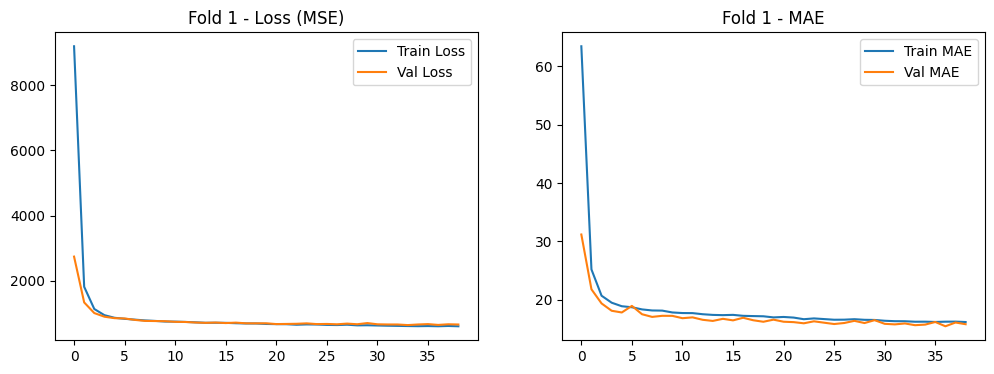

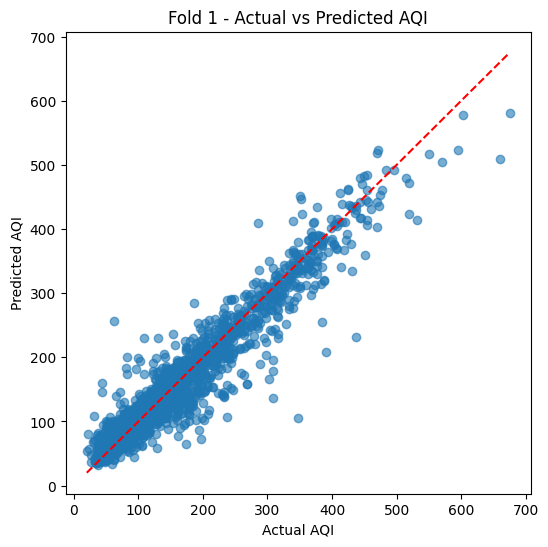

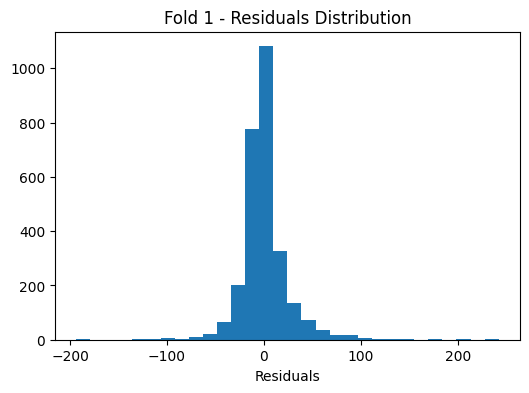

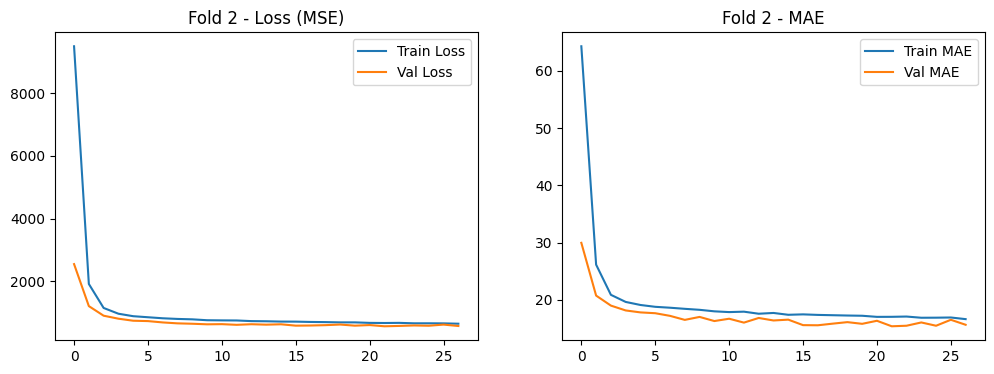

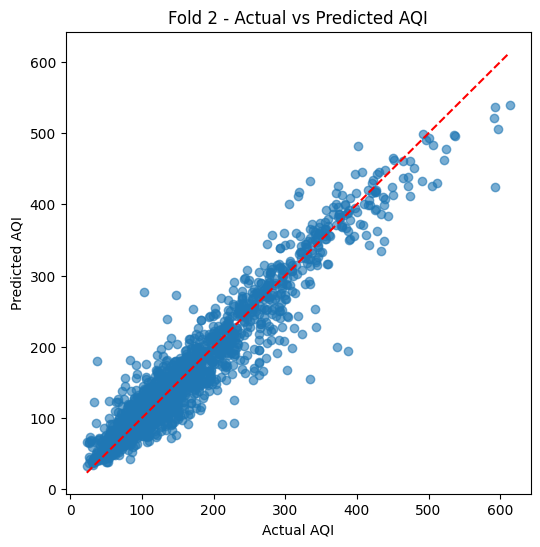

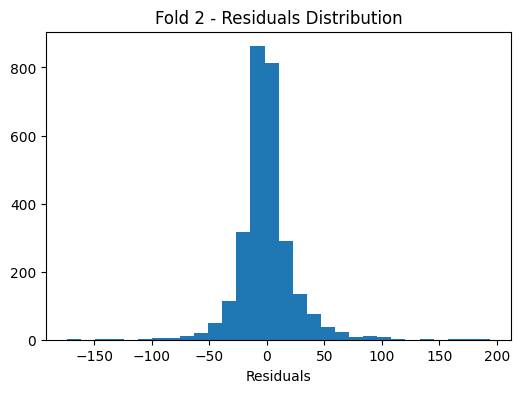

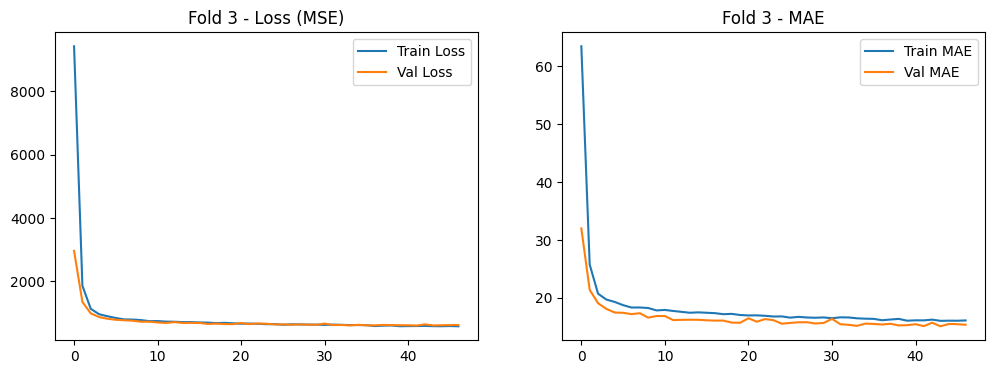

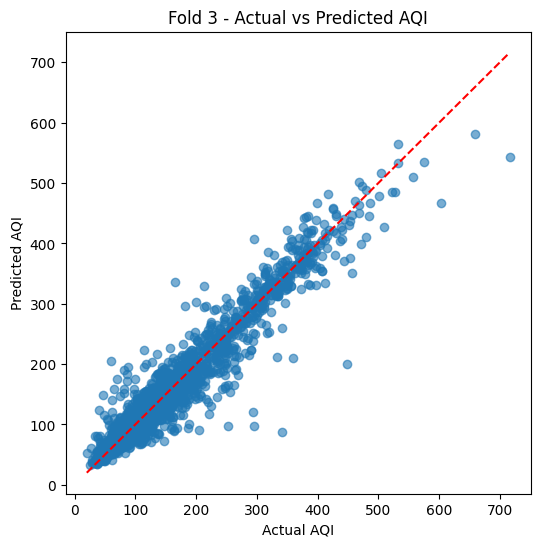

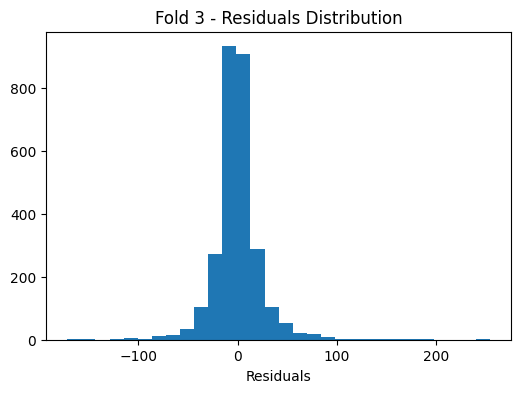

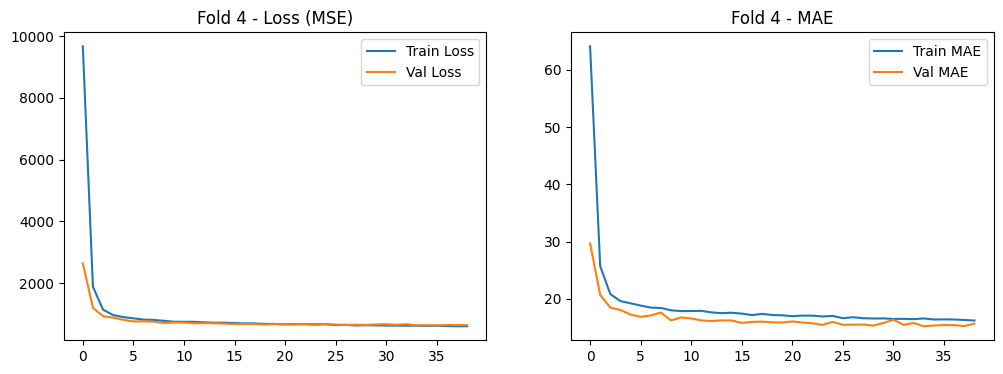

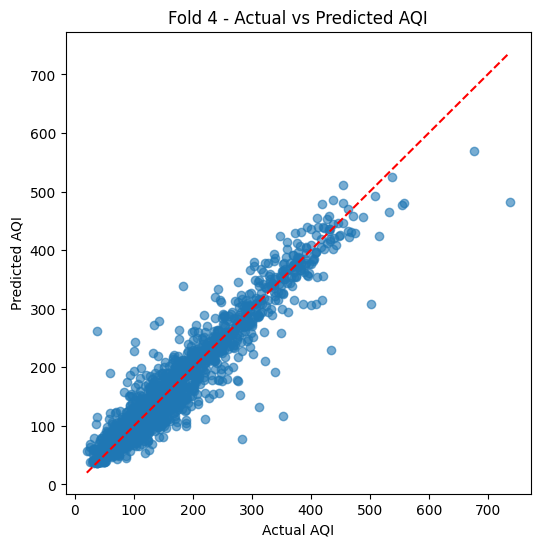

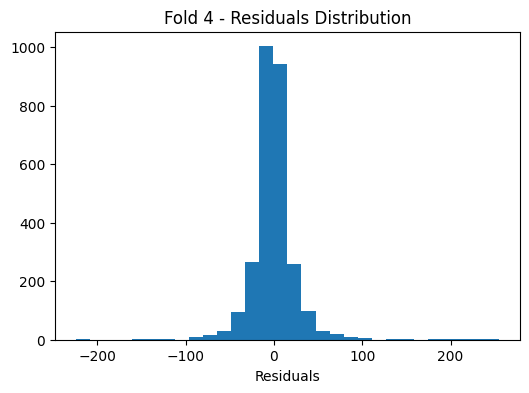

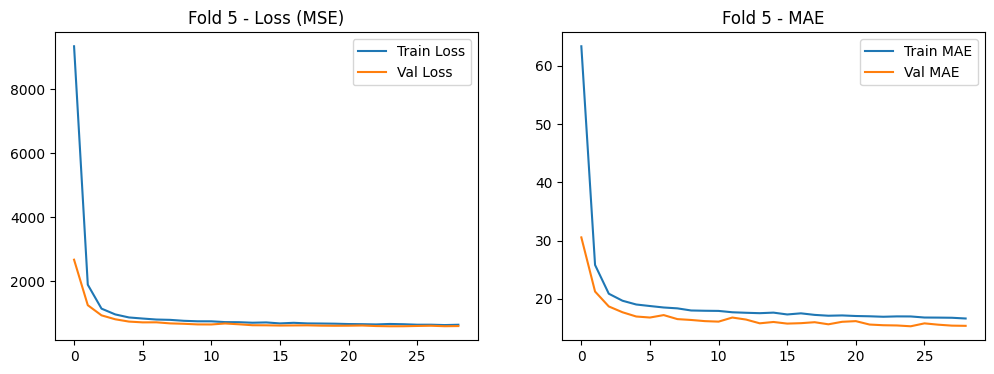

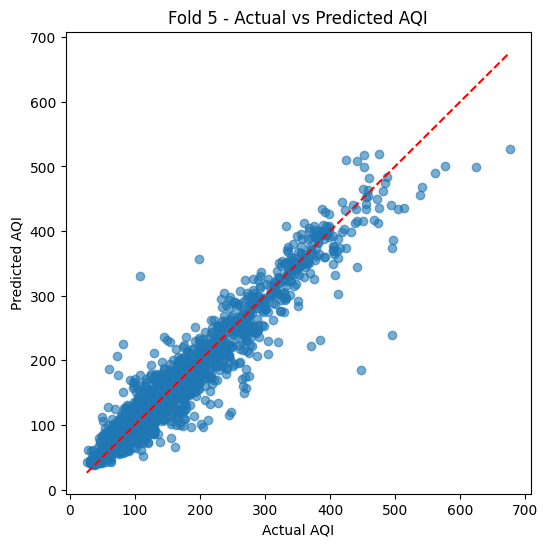

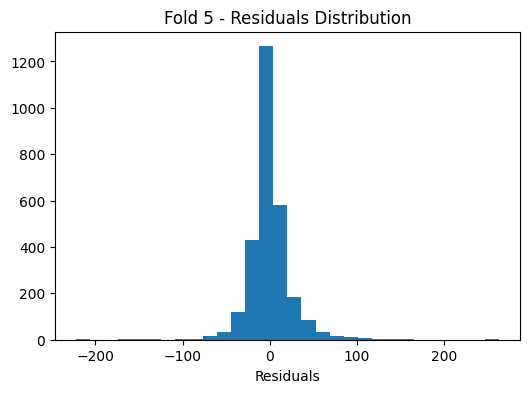

In [ ]:
for i, (history, metrics) in enumerate(zip(histories, fold_metrics)):
    # Loss & MAE
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {i+1} - Loss (MSE)')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title(f'Fold {i+1} - MAE')
    plt.legend()
    plt.show()

    # Predicted vs Actual
    plt.figure(figsize=(6,6))
    plt.scatter(metrics['y_val'], metrics['y_pred'], alpha=0.6)
    plt.xlabel('Actual AQI')
    plt.ylabel('Predicted AQI')
    plt.title(f'Fold {i+1} - Actual vs Predicted AQI')
    plt.plot([metrics['y_val'].min(), metrics['y_val'].max()], [metrics['y_val'].min(), metrics['y_val'].max()], 'r--')
    plt.show()

    # Residuals
    plt.figure(figsize=(6,4))
    plt.hist(metrics['y_val'] - metrics['y_pred'], bins=30)
    plt.xlabel('Residuals')
    plt.title(f'Fold {i+1} - Residuals Distribution')
    plt.show()

In [ ]:
# Aggregate metrics
maes = [m['mae'] for m in fold_metrics]
mses = [m['mse'] for m in fold_metrics]
r2s = [m['r2'] for m in fold_metrics]

print(f'Average MAE: {np.mean(maes):.4f} ± {np.std(maes):.4f}')
print(f'Average MSE: {np.mean(mses):.4f} ± {np.std(mses):.4f}')
print(f'Average R2: {np.mean(r2s):.4f} ± {np.std(r2s):.4f}')

Average MAE: 15.3640 ± 0.1836
Average MSE: 608.2920 ± 21.1018
Average R2: 0.9253 ± 0.0033
